In [1]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt
import numpy as np

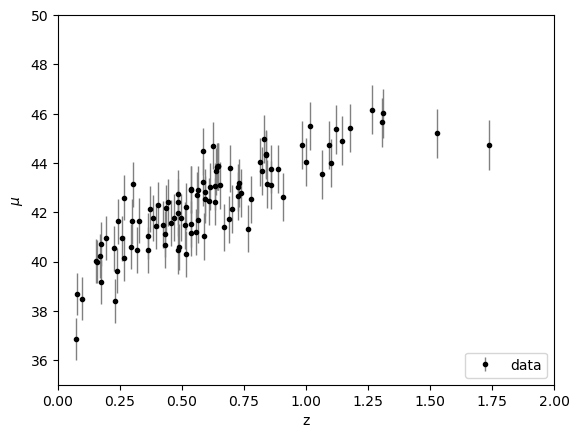

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [130]:
z = np.linspace(0,2, 100)

kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2) #default kernel is RBF (radial-basis function kernel)
gpr.fit(z_sample[:, None], mu_sample) #fitting gpr to our data
gpr_value, gpr_err = gpr.predict(z[:, None], return_std=True) #and predicting the expectation value and its std

print(gpr.kernel_)

30.7**2 * RBF(length_scale=3.9)


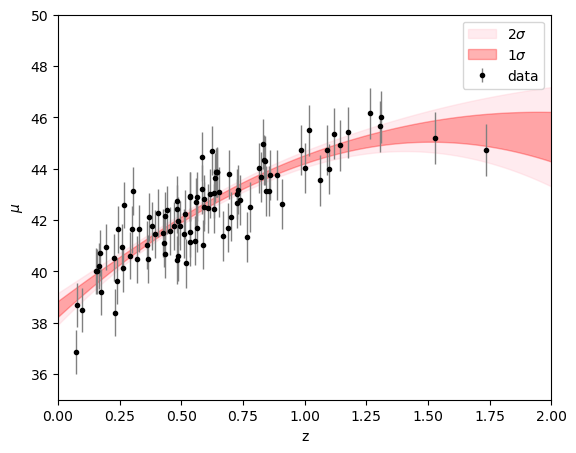

In [131]:
fig = plt.figure(figsize = (14, 5))

ax = fig.add_subplot(121)
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.set(xlabel = 'z', ylabel = '$\mu$', xlim = (0, 2), ylim = (35, 50))
ax.fill_between(z, gpr_value - 2 * gpr_err, gpr_value + 2 * gpr_err,  color='pink', alpha=0.3, label = '2$\sigma$')
ax.fill_between(z, gpr_value - gpr_err, gpr_value +  gpr_err,  color='red', alpha=0.3, label = '1$\sigma$')
plt.legend()

plt.legend()
plt.show()

Let's now cross validate the parameters of the kernels.

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_val, ydy_train, ydy_val = train_test_split(z_sample[:, None], np.array([mu_sample,dmu]).T, test_size = 0.3, random_state = 4)

y_train, dy_train = ydy_train.T
y_val, dy_val = ydy_val.T

In [133]:
def error_func(X, y, model):
    return np.sqrt( (1/len(X)) * (np.sum((y - model.predict(X, return_std=False)) ** 2)) )
    
def get_err (model):
    model.fit(X_train, y_train)
    error_train = error_func(X_train, y_train, model)
    error_val = error_func(X_val, y_val, model)
    return error_train, error_val

In [134]:
err_train = []
err_val = []

n_range = np.logspace(-3, 3, 9)
m_range = np.logspace(-2, 2, 5)

for m in m_range:
    kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(m, (1e-2, 1e2))
    model = GaussianProcessRegressor(kernel, alpha = dy_train **2)
    a, b = get_err(model)
    print(n, m, a, b)
    err_train.append(a)
    err_val.append(b)

#plt.plot(m_range, err_train, label = 'training error')
#plt.plot(m_range, err_val, label ='validation error')
#plt.legend()
#plt.show()

1000.0 0.01 0.9239921813697624 0.871473840731364
1000.0 0.1 0.923992187508417 0.87147385397282
1000.0 1.0 0.9239921859531975 0.8714738504003213
1000.0 10.0 0.9239921750690058 0.8714738388658542
1000.0 100.0 0.9239921791815279 0.8714738393253223


changing the bandwidth of RBF doesn't do much, let's try changing the constant kernel.

In [135]:
err_train = []
err_val = []

for n in n_range:
    kernel = kernels.ConstantKernel(n, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))
    model = GaussianProcessRegressor(kernel, alpha = dy_train **2)
    a, b = get_err(model)
    print(n, m, a, b)
    err_train.append(a)
    err_val.append(b)

0.001 100.0 0.9239921691355701 0.871473828268834
0.005623413251903491 100.0 0.923992154384234 0.8714738085298777
0.03162277660168379 100.0 0.9239921707485431 0.8714738314349338
0.1778279410038923 100.0 0.923992179091877 0.8714738378642501
1.0 100.0 0.9239921750690058 0.8714738388658542
5.623413251903491 100.0 0.923992161269297 0.8714737903434345
31.622776601683793 100.0 0.9239921894948231 0.871473852396925
177.82794100389228 100.0 0.923992104549835 0.8714737210609254
1000.0 100.0 0.9239921808126534 0.8714738437946802


Same thing actually...

In [136]:
err_train = []
err_val = []

for n in n_range:
    for m in m_range:
        kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(m, (1e-2, 1e2))
        model = GaussianProcessRegressor(kernel, alpha = dy_train **2)
        a, b = get_err(model)
        #print(n, m, a, b)
        err_train.append(a)
        err_val.append(b)
        if min(err_val) == b: n_min, m_min = n, m

print('min for n, min for m:', n_min, m_min)

min for n, min for m: 1000.0 10.0


In [137]:
z = np.linspace(0,2, 100)

kernel = kernels.ConstantKernel(1000.0, (1e-3, 1e3)) * kernels.RBF(10, (1e-2, 1e2))

gpr_best = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2) #default kernel is RBF (radial-basis function kernel)
gpr_best.fit(z_sample[:, None], mu_sample) #fitting gpr to our data
print(gpr_best.kernel_)

30.7**2 * RBF(length_scale=3.9)


I guess they are the same? GPR is able to get to the best parameters itself, at least within our constraints. Maybe we can try going out of them.